# Comparison of QAOA CVaR (Portfolio optimization)
In this notebook the QAOA version using the Conditional value at risk (CVaR) is compared to the standard QAOA for the problem of portfolio optimization. Both versions of QAOA are tested out using two different methods of incorporating the fixed budget constraint, namely the penalty method and the XY-mixer method. 

# Importing necessary modules

In [1]:
#run: pip install openquantumcomputing
from openquantumcomputing.QAOAPortfolioOptimization import QAOAPortfolioOptimization
from openquantumcomputing.QAOAPortfolioOptimization_mixer import QAOAPortfolioOptimization_mixer
from asset_loader import AssetData
from utilities_portOpt import computeMinMaxCosts, computeAverageApproxRatio, approxRatio
from qiskit import *
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *

# Creating problem instance

c:\Users\olaib\QuantumComputing\optimization\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


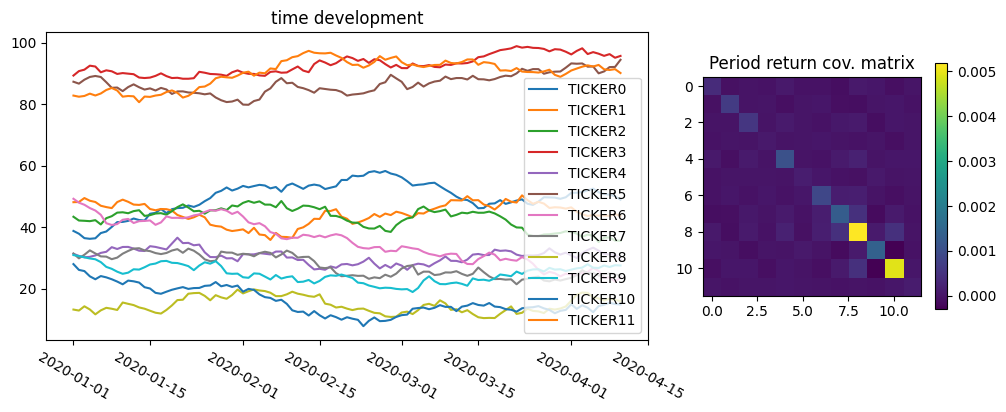

In [2]:
number_of_assets = 12
budget = 6

filename = os.path.join("data", "qiskit_finance_seeds.npz")
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()

# Creating QAOA instances for all methods
Below we create a standard QAOA instance and a QAOA instance using CVaR for both the penalty method and for the XY-mixer method.
The gamma_scale parameter is used to adjust the search range for the gamma parameter. 

For information about the scale parameter see Sebastian Brandhofer et al. “Benchmarking the performance of portfolio optimization with QAOA”. In: Quantum Information Processing 22.1 (2023), page 25-26)
or Zichang He et al. Alignment between Initial State and Mixer Improves QAOA Performance for 
Constrained Portfolio Optimization page 7 (2023)

In [3]:
gamma_scale = 5000 #Adjusts the search range for the gamma parameter 

alpha = 0.1     # value for CVaR (Conditional Value at Risk)
params_penalty = {
    "risk" : 0.5*gamma_scale,
    "budget": budget,
    "penalty": 4*gamma_scale, #Use optimal penalty?????
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return*gamma_scale,
    "usebarrier": False #OBS: only set to true for drawing NOT for simulations
}

params_XY_mixer = {
    "risk" : 0.5*gamma_scale,
    "budget": budget,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return*gamma_scale,
    "usebarrier": False #OBS: only set to true for drawing NOT for simulations
}

qaoaport_opt_penalty = QAOAPortfolioOptimization(params=params_penalty)                 #Not using CVaR
qaoaport_opt_XYmixer = QAOAPortfolioOptimization_mixer(params = params_XY_mixer)        #Not using CVaR

params_penalty["alpha"] = alpha
params_XY_mixer["alpha"] = alpha
qaoaport_opt_penalty_CVaR = QAOAPortfolioOptimization(params=params_penalty)            #Using CVaR
qaoaport_opt_XYmixer_CVaR = QAOAPortfolioOptimization_mixer(params = params_XY_mixer)   #Using CVaR

# Sampling cost landscape for all methods
Below the cost landscape is samples for all the methods. Note that the beta range is different for the penalty method and the XY-mixer method, due to different periods.


In [4]:
qaoaport_opt_penalty.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})
qaoaport_opt_penalty_CVaR.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})

qaoaport_opt_XYmixer.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,2*np.pi,10]})
qaoaport_opt_XYmixer_CVaR.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,2*np.pi,10]})

Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Its now computing the feasible subspace
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Its now computing the feasible subspace
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done


# Increasing depth

In [5]:
maxdepth=5
for i in range(maxdepth):
    qaoaport_opt_penalty.increase_depth()
    qaoaport_opt_penalty_CVaR.increase_depth()

    qaoaport_opt_XYmixer.increase_depth()
    qaoaport_opt_XYmixer_CVaR.increase_depth()

cost(depth= 1 )= 78885.20746716255
cost(depth= 1 )= 23.096632934006514
cost(depth= 1 )= 4.6457686404666765
cost(depth= 1 )= -24.83143757628323
cost(depth= 2 )= 50152.96820923864
cost(depth= 2 )= 15.084287095849183
cost(depth= 2 )= -0.7063059777598844
cost(depth= 2 )= -27.156838043469104
cost(depth= 3 )= 61325.45190863115
cost(depth= 3 )= 17.01652357394935
cost(depth= 3 )= -1.3186298313591238
cost(depth= 3 )= -28.173148132786164
cost(depth= 4 )= 46767.1311667625
cost(depth= 4 )= 12.204537100471356
cost(depth= 4 )= -1.4662931879942207
cost(depth= 4 )= -28.887912615972883
cost(depth= 5 )= 55449.36792566463
cost(depth= 5 )= 10.6403694751047
cost(depth= 5 )= -2.762775508722115
cost(depth= 5 )= -28.91433382030249


# Compute and print optimal solution with minium cost

In [6]:

cost_func = qaoaport_opt_penalty.cost
isFeasible_func = qaoaport_opt_penalty.isFeasible #These function are the same for all methoods


min_cost, max_cost, solution = computeMinMaxCosts(number_of_assets, cost_func, isFeasible_func)
print("Optimal solution: ", solution, "\n With cost: ", min_cost)

Optimal solution:  100100101011 
 With cost:  -29.063041157787666


# Compute approximation ratio

In [7]:
hists_penalty = [None]*maxdepth
hists_penalty_CVaR = [None]*maxdepth
hists_XYmixer = [None]*maxdepth
hists_XYmixer_CVaR = [None]*maxdepth
for i in range(maxdepth):
    hists_penalty[i] = qaoaport_opt_penalty.hist(qaoaport_opt_penalty.angles_hist['d'+str(i+1)+'_final'])
    hists_penalty_CVaR[i] = qaoaport_opt_penalty_CVaR.hist(qaoaport_opt_penalty_CVaR.angles_hist['d'+str(i+1)+'_final'])

    hists_XYmixer[i] = qaoaport_opt_XYmixer.hist(qaoaport_opt_XYmixer.angles_hist['d'+str(i+1)+'_final'])
    hists_XYmixer_CVaR[i] = qaoaport_opt_XYmixer_CVaR.hist(qaoaport_opt_XYmixer_CVaR.angles_hist['d'+str(i+1)+'_final'])

apprx_ratio_penalty = [None]*maxdepth
apprx_ratio_penalty_CVaR = [None]*maxdepth
apprx_ratio_XYmixer = [None]*maxdepth
apprx_ratio_XYmixer_CVaR = [None]*maxdepth

for i in range(maxdepth):
    apprx_ratio_penalty[i] = computeAverageApproxRatio(hists_penalty[i], max_cost, min_cost, cost_func, isFeasible_func)
    apprx_ratio_penalty_CVaR[i] = computeAverageApproxRatio(hists_penalty_CVaR[i], max_cost, min_cost, cost_func, isFeasible_func)
    apprx_ratio_XYmixer[i] = computeAverageApproxRatio(hists_XYmixer[i], max_cost, min_cost, cost_func, isFeasible_func)
    apprx_ratio_XYmixer_CVaR[i] = computeAverageApproxRatio(hists_XYmixer_CVaR[i], max_cost, min_cost, cost_func, isFeasible_func)


apprx_ratio_penalty2 = approxRatio(list(qaoaport_opt_penalty.costval.values()), max_cost, min_cost)
apprx_ratio_penalty_CVaR2 = approxRatio(list(qaoaport_opt_penalty_CVaR.costval.values()), max_cost, min_cost)
apprx_ratio_XYmixer2 = approxRatio(list(qaoaport_opt_XYmixer.costval.values()), max_cost, min_cost)
apprx_ratio_XYmixer_CVaR2 = approxRatio(list(qaoaport_opt_XYmixer_CVaR.costval.values()), max_cost, min_cost)

# Plot approximation ratio
Below the approximation ratio is plotted for all the methods.

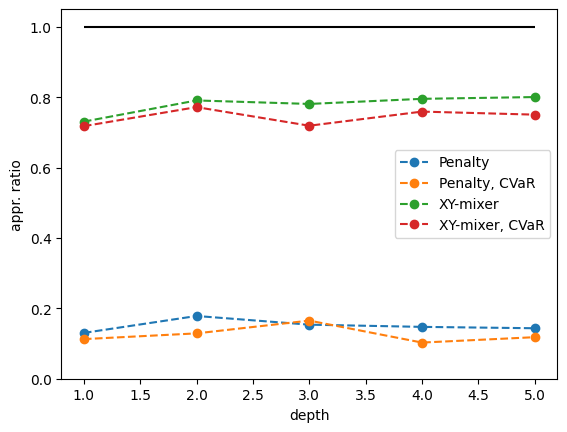

In [8]:
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty,'o--', label='Penalty')
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty_CVaR,'o--', label='Penalty, CVaR')
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer,'o--', label='XY-mixer')
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer_CVaR,'o--', label='XY-mixer, CVaR')
pl.ylim(0,1.05)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend()


# Plot approximation ratio (SECOND WAY)

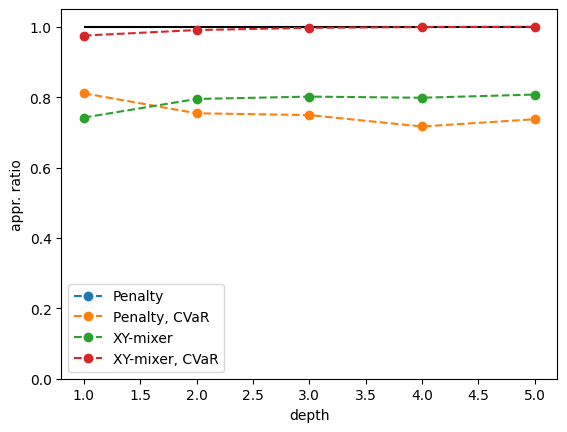

In [9]:
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty2,'o--', label='Penalty') #Negative values.....
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty_CVaR2,'o--', label='Penalty, CVaR')
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer2,'o--', label='XY-mixer')
pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer_CVaR2,'o--', label='XY-mixer, CVaR')
pl.ylim(0,1.05)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend()
